###

In [ ]:
%pwd

'/content'

In [ ]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
def load_and_preprocess_data(base_dir, img_size=(299, 299)):  #image 크기 지정
    images = [] # image data를 모으는 빈 리스트 생성
    labels = [] # label data를 모으는 빈 리스트 생성
    categories = ['NORMAL', 'PNEUMONIA']  #dataset의 데이터 카테고리 지정

    for category in categories: #normal 500, pne 500 1000개 데이터 뽑기
        class_num = categories.index(category) #카테고리별 클래스 넘버 부여(양성:1, 음성:0)
        base_path = os.path.join(base_dir, category)  #파일 경로 지정
        base_files = os.listdir(base_path)  #listdir: 파일에 접근
        np.random.shuffle(base_files) #img 섞기_랜덤성 부여
        for idx in range(500):
          image_path = os.path.join(base_path, base_files[idx]) #image 파일 경로 지정
          image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  #img 불러오기(grayscale로 변환해서 불러옴)
          image = cv2.resize(image, img_size) #img 리사이즈(크기 지정)
          images.append(image)    #image 리스트에 image 추가
          labels.append(class_num)      #labels 리스트에 class_num 추가

    images = np.array(images).reshape(-1, img_size[0], img_size[1], 1) #(~~~, 1 = gray scale)
    return images, np.array(labels) #list 데이터를 array타입으로 변경

def split_data(X, y, test_size=0.2, val_size=0.5): #train 8, val 1, test 1
    X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42) #train data 80%로 분할 / stratify: 클래스의 비율 맞춰서 분할
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=val_size, stratify=y_val_test, random_state=42) #20%의 val,test data 1:1비율로 분할
    return X_train, y_train, X_val, y_val, X_test, y_test #분리된 데이터 반환

In [ ]:
base_dir = '/content/drive/MyDrive/Pneumonia.zip (Unzipped Files)/train'  #드라이브의 파일 경로 작성
X, y = load_and_preprocess_data(base_dir)   #데이터 로드

X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y) #데이터 분할

print("데이터 로딩 및 전처리 완료")
print(f"훈련 데이터 형태: {X_train.shape}, 레이블 형태: {y_train.shape}")
print(f"검증 데이터 형태: {X_val.shape}, 레이블 형태: {y_val.shape}")
print(f"테스트 데이터 형태: {X_test.shape}, 레이블 형태: {y_test.shape}")

데이터 로딩 및 전처리 완료
훈련 데이터 형태: (800, 299, 299, 1), 레이블 형태: (800,)
검증 데이터 형태: (100, 299, 299, 1), 레이블 형태: (100,)
테스트 데이터 형태: (100, 299, 299, 1), 레이블 형태: (100,)


In [ ]:
def create_simple_cnn(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape), #32개의 필터, 3x3 크기, relu 활성화 함수 사용
        MaxPooling2D((2, 2)), # 풀링 2x2
        Conv2D(64, (3, 3), activation='relu'),  # 64개의 필터, 3x3
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),  #가장 큰 특징들 모아서 1차원으로 변환
        Dense(64, activation='relu'), #완전 연결층
        Dense(1, activation='sigmoid') #이진분류를 위한 손실함수// Dense(2, activation='softmax), model.compile(~~~, lose='sparse_crossentropy'): 멀티 클래스
        ])
    return model  #model(클래스 인스턴스) 객체 반환

In [ ]:
#model compile
input_shape = (299, 299, 1) #299x299, 채널값(1: gray scale)
model = create_simple_cnn(input_shape)  #모델 생성

model.compile(optimizer='adam',
              loss='binary_crossentropy', #sigmoid와 함께 사용
              metrics=['accuracy'])

early_stopping = EarlyStopping(   #특정조건을 만족하면 early stop; overfitting 방지
    monitor='val_loss',   #val_loss값 모니터링, 지정한 지표 감소하는지 확인
    patience=10,    #지정한 epoch 횟수만큼(<- 10번) val_loss 감소(개선)하지 않을 때 Early stopping
    verbose=1,  #결과값 출력 (0이 default, 0일때는 출력X)
    mode='min', #loss값 최솟값으로 찾기
    restore_best_weights=True   #조기 종료 시 가장 좋은 성능을 보였을 때의 가중치 저장
)

model_checkpoint = ModelCheckpoint( #모델 학습하는 동안 일정한 간격으로 모델의 가중치 저장, 최상 성능 모델 선택 기능
    'best_model.h5',  #가중치 이름을 'best_model.h5'로 저장
    monitor='val_accuracy',   #'val_accuracy'를 모니터링
    mode='max',   #'val_accuracy' 최대화하는 방향으로 진행
    verbose=1, # 결과값 출력
    save_best_only=True   #가장 좋은 성능을 보인 가중치만 저장
)

model.summary() #모델 내용 출력

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 297, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 148, 148, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 322624)            0

In [ ]:
history = model.fit(    #모델 학습 후 history  객체에 저장
    X_train, y_train,   #훈련시킬 데이터 가져오기
    validation_data=(X_val, y_val),   #모델 평가할 데이터로 X_val, y_val 지정
    epochs=100,   #100번 학습, early stop 해뒀기 때문에 overfitting 방지됨
    batch_size=32,  #한 번에 모델이 학습하는 데이터 샘플의 갯수 32개로 설정
    callbacks=[early_stopping, model_checkpoint]  #모델 학습 중 호출할 콜백함수 리스트[early_stopping, model_checkpoint]
)

model = tf.keras.models.load_model('best_model.h5') #가중치값 저장하는 확장명/ 학습 후 가장 높은 성능을 나타낸 가중치를 불러옴

Epoch 1/100
25/25 [==============================] - ETA: 0s - loss: 124.7492 - accuracy: 0.5863
Epoch 1: val_accuracy improved from -inf to 0.78000, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 11s 143ms/step - loss: 124.7492 - accuracy: 0.5863 - val_loss: 2.1385 - val_accuracy: 0.7800
Epoch 2/100
25/25 [==============================] - ETA: 0s - loss: 0.6822 - accuracy: 0.8487
Epoch 2: val_accuracy improved from 0.78000 to 0.93000, saving model to best_model.h5
25/25 [==============================] - 4s 156ms/step - loss: 0.6822 - accuracy: 0.8487 - val_loss: 0.4775 - val_accuracy: 0.9300
Epoch 3/100
25/25 [==============================] - ETA: 0s - loss: 0.2351 - accuracy: 0.9350
Epoch 3: val_accuracy did not improve from 0.93000
25/25 [==============================] - 2s 72ms/step - loss: 0.2351 - accuracy: 0.9350 - val_loss: 0.4843 - val_accuracy: 0.9300
Epoch 4/100
25/25 [==============================] - ETA: 0s - loss: 0.1039 - accuracy: 0.9613
Epoch 4: val_accuracy did not improve from 0.93000
25/25 [==============================] - 2s 70ms/step - loss: 0.1039 - accuracy: 0.9613 - val_loss: 0.6861 - val_accuracy: 0.8500
Ep

NameError: name 'tf' is not defined

In [ ]:
tes_loss, test_acc = model.evaluate(X_test, y_test) #X_test,y_test데이터에 대한 손실값과 평가지표를 각각 test_loss(손실값), test_acc(정확도)에 반환
print(f"Test Accuracy: {test_acc:.4f}")   #정확도 출력 (소수점 4번째까지)

4/4 [==============================] - 0s 20ms/step - loss: 0.2700 - accuracy: 0.9000
Test Accuracy: 0.9000


In [ ]:
y_pred = model.predict(X_test)    #X_test 값에 대해 계산한 예측값을 y_pred에 저장
y_pred_classes = (y_pred >0.5).astype(int).flatten()
#output에서 sigmoid함수를 사용했으므로 출려값이 [0,1] 범위 값으로 출력.
#예측값이 0.5보다 크면 1(양성,Pneumonia)로, 작으면 0(음성,Normal)으로 분류

4/4 [==============================] - 0s 22ms/step


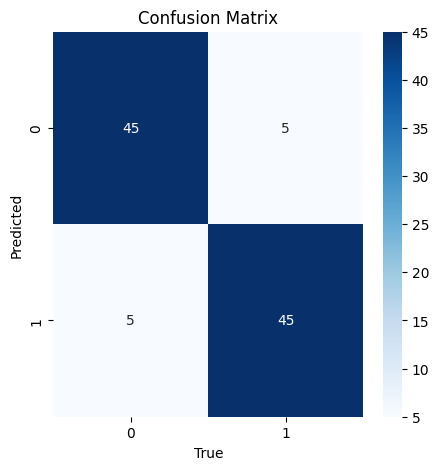

In [ ]:
cm = confusion_matrix(y_test, y_pred_classes)  # confusion matrix 생성

plt.figure(figsize=(5,5)) #그림 크기 지정
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  #cm: 오차행렬, annot = True : 각 셀 데이터수 표시, fmt=d: 숫자 정수형식, cmap=Blues: 색상 blues
plt.title('Confusion Matrix') #타이틀
plt.xlabel('True')  #x축 레이블 설정
plt.ylabel('Predicted') #y축 레이블 설정
plt.show()  #그래프 출력

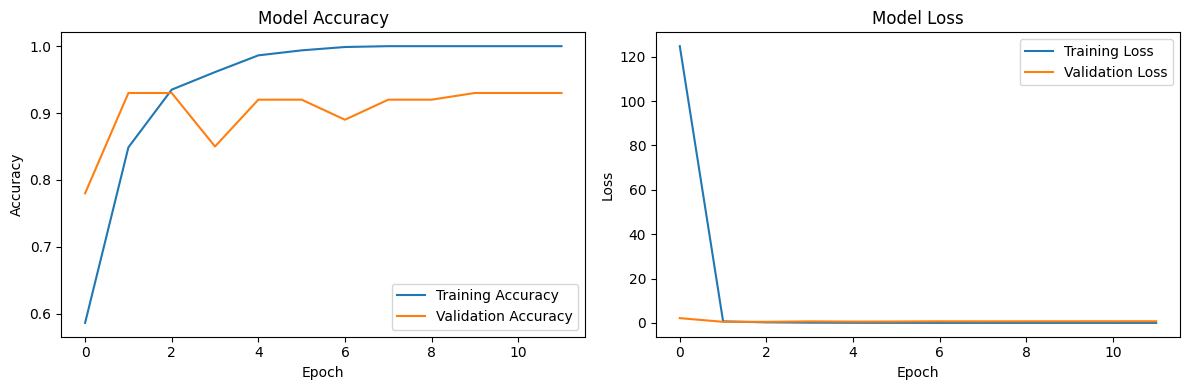

In [ ]:
plt.figure(figsize=(12, 4))   #그림 크기 설정
plt.subplot(1, 2, 1)  #그림을 1개의 행, 2개의 열로 나누고 1번째 위치에 배치(하나의 그림안에 여러개의 작은 그래프를 배열 형태로 배치할 수 있는 기능)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy') #타이틀
plt.xlabel('Epoch') #x축 레이블
plt.ylabel('Accuracy')    #y축 레이블
plt.legend()  #범례 추가

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()  #subplot간 간격 자동 조정
plt.show()

### InceptionV3

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3 #ResNet50V2, VGG16, Xception, EfficientNetB0, MobileNetV3Small
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
def create_inceptionv3_model(input_shape):  #input shape만 입력해주면 됨
  base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
  #ImageNet이라는 대용량 데이터셋으로 사전학습된 InceptionV3 모델 가져오기
  #include_top: 전이 학습(transfer learning) True: 시작부터 완전 연결 계층까지 그대로 가져다 사용
  #사전 학습된 모델에서 사용된 기존 완전연결 계층 부분 사용 여부(ImageNet의 경우 클래스가 1000개이고, 현재 데이터셋은 클래스가 2개이므로 그대로 사용 불가->include_top=False로 작성)
  base_model.trainable = False  #기본 모델 가중치 동결

  #완전 연결 계층(inference)
  x = base_model.output # base_model의 출력을 x에 할당
  x = GlobalAveragePooling2D()(x) #GlobalAveragePooling2D 층을 사용하여  평균풀링적용 (각 채널별로 평균을 구하고, 공간적인 차원을 줄임.) // (x): 집어넣는 입력값 ex.f(x)
  x = Dense(1024, activation='relu')(x) # 1024개의 뉴런을 가진 완전 연결(Dense) 층으로 평균풀링후의 출력을 입력으로 받음.
  output = Dense(1, activation='sigmoid')(x)  #출력 계층

  model = Model(inputs=base_model.input, outputs=output)   #모델 생성

  return model  #모델 반환

### Inception용 data 처리
- channel 1->3

In [ ]:
# X_train_rgb(이미지 데이터를 RGB로 확장한 데이터) 전처리
X_train_rgb = np.repeat(X_train, 3, axis=-1)  #3차원 배열로 변환(RGB를 grayscale만 3개로 할당)
X_val_rgb = np.repeat(X_val, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

#Inception용 전처리
X_train_preprocessed = tf.keras.applications.inception_v3.preprocess_input(X_train_rgb)
X_val_preprocessed = tf.keras.applications.inception_v3.preprocess_input(X_val_rgb)
X_test_preprocessed = tf.keras.applications.inception_v3.preprocess_input(X_test_rgb)

model = create_inceptionv3_model((299, 299, 3)) #모델 생성, 3: rgb값
#model compile
model.compile(optimizer=Adam(learning_rate=0.001),    # Adam알고리즘을 사용하여 모델을 최적화. learning rate로, 모델이 각 반복에서 가중치를 업데이트할 때 사용하는 스케일 파라미터
              loss='binary_crossentropy',   # 손실 함수로 binary_crossentropy사용
              metrics=['accuracy'])   # 모델의 성능을 평가하는 지표로 accuracy 사용

#콜백 함수 설정
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_inception_model.h5', save_best_only=True)
]

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
history = model.fit(    #모델 학습
    X_train_preprocessed, y_train,
    validation_data=(X_val_preprocessed, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 0.9828 - accuracy: 0.7050

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 19s 371ms/step - loss: 0.9828 - accuracy: 0.7050 - val_loss: 0.3376 - val_accuracy: 0.8500
Epoch 2/50
25/25 [==============================] - 5s 185ms/step - loss: 0.2112 - accuracy: 0.9187 - val_loss: 0.2135 - val_accuracy: 0.9200
Epoch 3/50
25/25 [==============================] - 5s 203ms/step - loss: 0.1803 - accuracy: 0.9312 - val_loss: 0.1830 - val_accuracy: 0.9200
Epoch 4/50
25/25 [==============================] - 5s 193ms/step - loss: 0.1425 - accuracy: 0.9488 - val_loss: 0.1751 - val_accuracy: 0.9100
Epoch 5/50
25/25 [==============================] - 5s 190ms/step - loss: 0.1331 - accuracy: 0.9575 - val_loss: 0.1528 - val_accuracy: 0.9300
Epoch 6/50
25/25 [==============================] - 4s 156ms/step - loss: 0.1094 - accuracy: 0.9675 - val_loss: 0.1541 - val_accuracy: 0.9400
Epoch 7/50
25/25 [==============================] - 5s 196ms/step - loss: 0.1086 - accuracy: 0.9625 - val_loss: 0.1490 - val_accuracy: 0.9400
Epoch 8/50
25/25

In [ ]:
model = tf.keras.models.load_model('best_inception_model.h5')

In [ ]:
test_loss, test_acc = model.evaluate(X_test_preprocessed, y_test)
print(f'Test accuracy: {test_acc:.4f}')

4/4 [==============================] - 2s 102ms/step - loss: 0.1158 - accuracy: 0.9400
Test accuracy: 0.9400


4/4 [==============================] - 2s 141ms/step


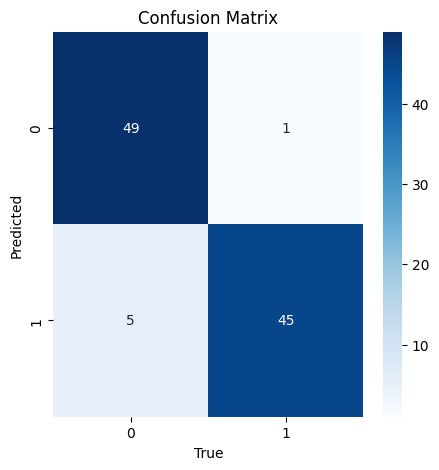

In [ ]:
y_pred = model.predict(X_test_preprocessed)
y_pred_classes = (y_pred>0.5).astype(int)

# confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

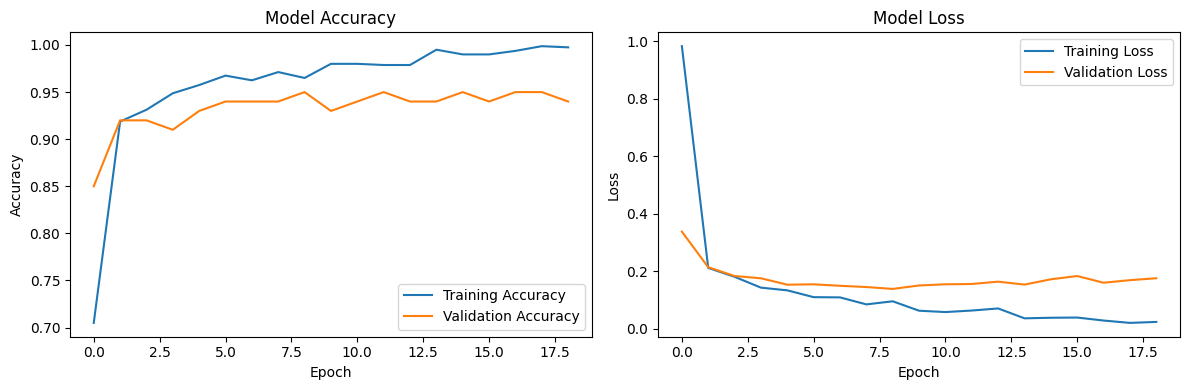

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

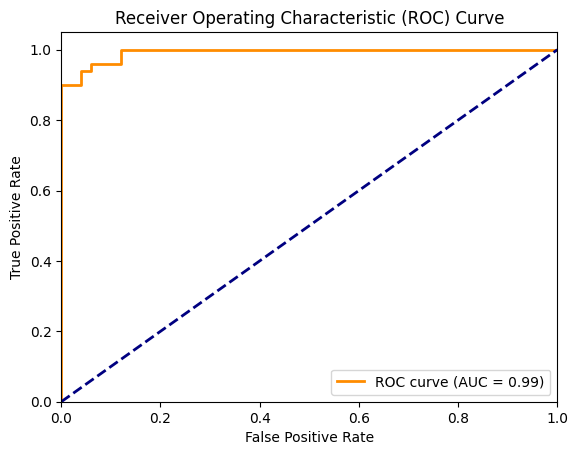

In [ ]:
from sklearn.metrics import roc_curve, auc

# ROC 곡선 계산
fpr, tpr, _ = roc_curve(y_test, y_pred) # 실제 클래스와 모델 예측을 기반으로 거짓 양성 비율과 참 양성 비율 계산
roc_auc = auc(fpr, tpr)   # ROC 곡선의 면적인 AUC 계산

# ROC 곡선 그리기
plt.figure()  #새로운 플롯 생성
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')  # ROC 곡선 그리기
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 기준선(랜덤 분류의 경우의 대각선) 그리기
plt.xlim([0.0, 1.0])  #x축 범위 설정
plt.ylim([0.0, 1.05]) #y축 범위 설정
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')ㅈ
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right") #범례 위치 설정
plt.show()  #그래프 출력